https://arxiv.org/pdf/1706.03762.pdf
http://mlexplained.com/2017/12/29/attention-is-all-you-need-explained/
https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/
http://jalammar.github.io/illustrated-transformer/
https://www.reddit.com/r/MachineLearning/comments/6jdi87/r_question_about_positional_encodings_used_in/

In [1]:
import numpy as np

def load_corpus(filename, tagged=True):
    with open(filename, "r") as f:
        sentences = []
        words = {}
        for line in f:
            sentence = []
            pairs = line.rstrip('\n').split(' ')
            for pair in pairs:
                if pair != '':
                    if tagged == True:
                        word, tag = pair.split('/')
                        sentence.append((word, tag))
                        words[(word, tag)] = words.get((word, tag), 0) + 1                    
                    else:
                        sentence.append(pair)
                        words[pair] = words.get(pair, 0) + 1
            sentences.append(sentence)


        return words, sentences

In [2]:
words, sents = load_corpus('../corpora/oe/oe.all_features')

In [3]:
def build_alphabet(words):
    alphabet = {}
    max_word_len = 0
    
    for word in words:
        max_word_len = max(len(word), max_word_len)
        for letter in word:
            alphabet[letter] = alphabet.get(letter, 0) + 1
            
    return list(alphabet.keys()), max_word_len

In [5]:
alpha, max_word_len = build_alphabet([word for word,_ in words.keys()])
max_word_len = 12

In [6]:
max_sent_len = 48

In [7]:
from keras.utils.np_utils import to_categorical

feature_names = ['pos', 'person', 'number', 'tense', 'mood', 'voice', 'gender', 'case', 'degree', 'strength', 'inflection']

def indexify(string_list):
    vocab = list(set(string_list))
    return np.asarray([vocab.index(elem)+1 for elem in string_list]), vocab

def convert_morphology(tagged_words):
    slicers = [(0,2),2,3,4,5,6,7,8,9,10,11]
    feature_tags = [[] for _ in slicers]
    
    for _, tag in tagged_words:
        for i, slicer in enumerate(slicers):
            start, end = slicer if type(slicer) == tuple else (slicer, slicer + 1)
            feature_tags[i].append(tag[start:end])
        
    vectors = []
    label_sets = []
    indices = []
    for feature in feature_tags:
        idx, labels = indexify(feature)
        label_sets.append(labels)
        indices.append(idx)
        vectors.append(to_categorical(idx))
        
    return vectors, label_sets, indices

Using TensorFlow backend.


In [9]:
def select_letter_indices(word, alphabet, max_word_len):
    v = np.zeros((max_word_len))
    
    for i in range(min(len(word), max_word_len)):
        v[i] = alphabet.index(word[i]) + 1 if word[i] in alphabet else 0
        
    return v
    
def create_char_dataset(tagged_words, sentences, alphabet, max_sent_len, max_word_len):
    num_sentences = len(sentences)
    X = np.zeros((num_sentences, max_sent_len, max_word_len), dtype='int32')
    
    tagged_tokens = []
    for i, sent in enumerate(sentences):
        sent_len = len(sent)
        for j, (word, tag) in enumerate(sent):
            if j >= max_sent_len:
                break
            tagged_tokens.append((word, tag))
            X[i, j, :] = select_letter_indices(word, alphabet, max_word_len)
        
    features, labels, _ = convert_morphology(tagged_tokens)
    
    Y = [np.zeros((num_sentences, max_sent_len, F.shape[1])) for F in features]
    i = 0
    for j, sent in enumerate(sentences):
        for k in range(min(max_sent_len, len(sent))):
            for f in range(len(features)):
                Y[f][j, k, :] = features[f][i]
            i += 1

    return X, Y, labels, tagged_tokens

In [10]:
np.random.shuffle(sents)
X, Y, labels, _ = create_char_dataset(words, sents, alpha, max_sent_len, max_word_len)

In [11]:
X.shape, Y[0].shape

((2536, 48, 12), (2536, 48, 19))

In [12]:
X_test, Y_test = X[-110:], [y[-110:] for y in Y]
X = X[:-110]
Y = [y[:-110] for y in Y]

In [15]:
def load_vocab(filename):
    vocab = {}
    rev_vocab = {}
    
    with open(filename, 'r') as f:
        for pair in f:
            idx, word = pair.split()
            vocab[word] = int(idx)
            rev_vocab[int(idx)] = word
            
    return vocab, rev_vocab

In [16]:
vocab, rev_vocab = load_vocab('../models/oe/oe_types.txt')

In [17]:
len(vocab)

325198

In [22]:
import pickle

def load_vectors(filename):
    with open(filename, 'rb') as f:
        vectors = pickle.load(f)
        
    vectors = np.concatenate([np.zeros((1,300)),vectors],axis=0)
    norm_vectors = np.divide(vectors, np.linalg.norm(vectors, axis=-1, keepdims=True))
    norm_vectors[0] = 0
    
    return norm_vectors

In [23]:
vectors = load_vectors('../models/oe/oe_vectors.bin')

/home/jds/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [24]:
def create_word_dataset(sentences, vocab, max_sent_len):
    X = np.zeros((len(sentences), max_sent_len))
    for i, sent in enumerate(sentences):
        for j, (word, _) in enumerate(sent):
            if j == max_sent_len:
                break
            X[i,j] = vocab[word]
            
    return X

In [25]:
X2 = create_word_dataset(sents, vocab, max_sent_len)
X2_train = X2[:-110]
X2_test = X2[-110:]

In [227]:
from keras import layers, Input
from keras.models import Model, Sequential
from keras import regularizers
import tensorflow as tf
import keras.backend as K

def positional_encoding(max_sent_len, num_dims):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (i // 2) / num_dims) for i in range(num_dims)] 
        if pos != 0 else np.zeros(num_dims) 
        for pos in range(max_sent_len)])
    
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    
    return K.constant(pos_enc)

In [198]:
def project_2d(n_cols):
    return layers.TimeDistributed(layers.Dense(n_cols, use_bias=False))

In [199]:
def scaled_dot_product(q, k, v, d_k):
    dot = layers.dot([q, k], axes = [2,2])
    normed_dot = layers.Lambda(lambda x: tf.divide(x, np.sqrt(d_k)))(dot)
    softmax = layers.Activation('softmax')(dot)
    att = layers.dot([softmax, v], axes=[2,1])
    
    return att

In [200]:
def attention_head(q, k, v, d_k, d_v):
    q_proj = project_2d(d_k)(q)
    k_proj = project_2d(d_k)(k)
    v_proj = project_2d(d_v)(v)
    
    attend = scaled_dot_product(q_proj, k_proj, v_proj, d_k)
    
    return attend

In [214]:
def multi_headed_attention(q, k, v, d_model, h, d_k, d_v):
    heads = []
    for _ in range(h):
        heads.append(attention_head(q, k, v, d_k, d_v))
    concat = layers.concatenate(heads, axis=-1)
    return project_2d(d_model)(concat)

In [230]:
def positionwise_feedforward(d_model, d_ff):
    model = Sequential()
    model.add(layers.Conv1D(d_ff, 1, activation='relu'))
    model.add(layers.Conv1D(d_model, 1))
    model.add(layers.BatchNormalization())
    
    return model

In [236]:
def make_transformer(
    word_vectors,
    max_sent_len, 
    morpho_sizes,
    morpho_names,
    h = 8,
    d_model=256,
    d_ff = 512):
    
    d_k = d_model // h
    d_v = d_k
    
    # The Word portion
    # word vectors
    word_embed = layers.Embedding(word_vectors.shape[0],
                                  word_vectors.shape[1],
                                  input_length=max_sent_len,
                                  weights=[word_vectors],
                                  trainable = False,
                                  mask_zero = True)
    
    word_input = Input(shape=(max_sent_len,), dtype='float32')
    word_vectors = word_embed(word_input)
    word_vectors = layers.Dense(d_model)(word_vectors)
    
    # add the positional encodings to the word vectors
    positional_encodings = positional_encoding(max_sent_len, d_model)
    word_pos_vectors = layers.Lambda(lambda x: np.add(x, positional_encodings))(word_vectors)
    
    prev_vectors = word_pos_vectors
    
    for _ in range(6):
        q = k = v = prev_v

        attended = multi_headed_attention(q, k, v, d_model, h, d_k, d_v)
        attended = layers.BatchNormalization()(layers.add([attended, word_pos_vectors]))
        ff = positionwise_feedforward(d_model, d_ff)(attended)
        ff = layers.BatchNormalization()(layers.add([attended, ff]))
    
    out = layers.Dense(d_model, activation='relu')(ff)
    out = layers.Dropout(0.2)(out)
    out = layers.Dense(d_model, activation='relu')(out)
    out = layers.Dropout(0.2)(out)
   
    outputs = [layers.Dense(morpho_size, activation='softmax', name=morpho_names[i])(out) for i, morpho_size in enumerate(morpho_sizes)]

    
    model = Model(word_input, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    
    return model

In [237]:
K.clear_session()
m1 = make_transformer(vectors, 
                      max_sent_len,
                      [y.shape[2] for y in Y],
                      feature_names)
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 48, 300)      97559700    input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 48, 256)      77056       embedding_1[0][0]                
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 48, 256)      0           dense_1[0][0]                    
__________________________________________________________________________________________________
time_distr

A callback will help visualize the training process.  Three plots will be produced:

1.  Training and validation losses.
2.  Training accuracy for each feature type.
3.  Validation accuracy for each feature type. 

In [174]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.accs = {}
        self.val_accs = {}
        for f in feature_names:
            self.accs[f] = []
            self.val_accs[f] = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        for f in feature_names:
            self.accs[f].append(logs.get(f + '_acc'))
            self.val_accs[f].append(logs.get('val_' + f + '_acc'))
        self.i += 1
        
        clear_output(wait=True)
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(20, 10))
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        
        for f in feature_names:
            ax2.plot(self.x, self.accs[f], label=(f + "_acc"))
            ax3.plot(self.x, self.val_accs[f], label="val_" + f + "_acc")
            
        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.show();
        
        for f in feature_names:
            print(f +  " best:", np.round(np.max(self.val_accs[f]), 3), "last:", np.round(self.val_accs[f][-1], 3))
        
plot_losses = PlotLosses()

Now we are ready to train the model.  A smaller batch-size seems to work earlier on, though in a careful training regime it emerges that increasing the batch size later yields slightly higher test accuracy.

We will split the training dataset again 95/05 so that a validation ("dev") set will provide information about the fitting process.


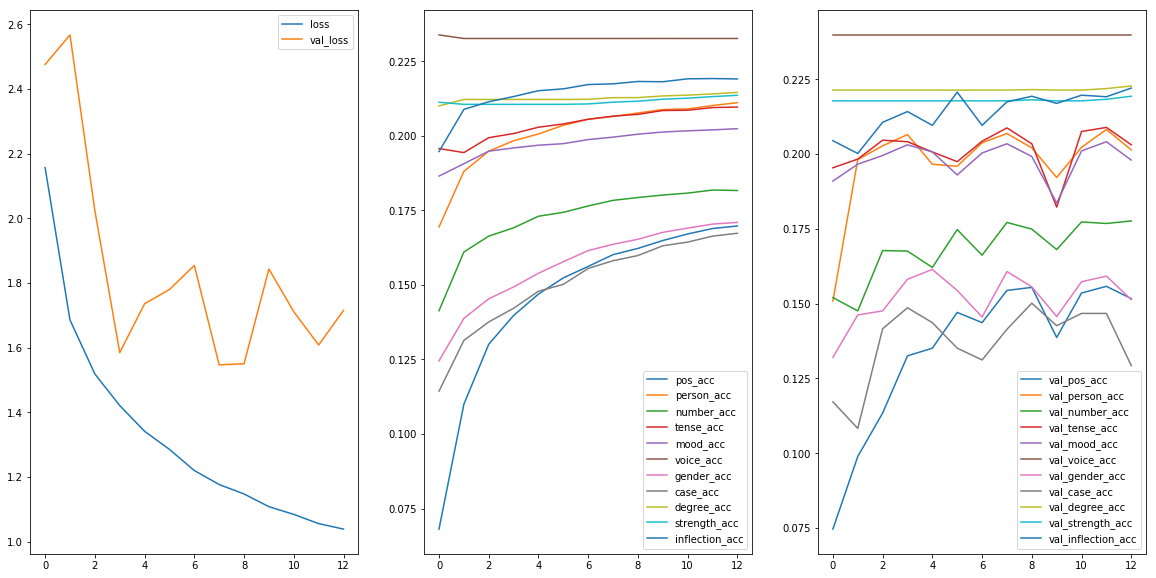

pos best: 0.156 last: 0.152
person best: 0.208 last: 0.201
number best: 0.178 last: 0.178
tense best: 0.209 last: 0.203
mood best: 0.204 last: 0.198
voice best: 0.24 last: 0.24
gender best: 0.161 last: 0.151
case best: 0.15 last: 0.129
degree best: 0.223 last: 0.223
strength best: 0.219 last: 0.219
inflection best: 0.222 last: 0.222
Epoch 14/50
1696/2304 [=====================>........] - ETA: 3s - loss: 1.0147 - pos_loss: 0.1871 - person_loss: 0.0608 - number_loss: 0.1255 - tense_loss: 0.0582 - mood_loss: 0.0918 - voice_loss: 2.4582e-05 - gender_loss: 0.1576 - case_loss: 0.1706 - degree_loss: 0.0636 - strength_loss: 0.0630 - inflection_loss: 0.0366 - pos_acc: 0.1732 - person_acc: 0.2131 - number_acc: 0.1838 - tense_acc: 0.2122 - mood_acc: 0.2045 - voice_acc: 0.2347 - gender_acc: 0.1737 - case_acc: 0.1705 - degree_acc: 0.2164 - strength_acc: 0.2157 - inflection_acc: 0.2213

KeyboardInterrupt: 

In [233]:
history = m1.fit(X2_train, [y for y in Y],
                 batch_size=16, epochs=50,
                 callbacks=[plot_losses],
                 validation_split = 0.05)

## Results

Let's evaluate the model against the test set, the same that was used in evaluating the Perceptron tagger above.

In [104]:
dict(zip(feature_names, np.round(m1.evaluate([X_test, X2_test], [y for y in  Y_test], batch_size=256)[-11:], 3)))

110/110 [==============================] - 1s 6ms/step


{'case': 0.858,
 'degree': 0.935,
 'gender': 0.858,
 'inflection': 0.965,
 'mood': 0.967,
 'number': 0.91,
 'person': 0.979,
 'pos': 0.918,
 'strength': 0.954,
 'tense': 0.979,
 'voice': 1.0}

Comparing this result to the Perceptron tagger above, we see that the Word+Char model improves on NLTK's AveragedPerceptron across all features, and especially so for the POS tagging task.  

The POS accuracy of 0.918 puts the Word+Char in the range of the Germanic taggers tested by Horsmann and Zesch, though somewhat on the lower end.

| Feature | Perceptron Tagger | Word+Char LSTM | Diff |
----------|-------------------|----------------|------|
|  POS | 0.840 | 0.918 | + 7.8% |
| Person | 0.956 | 0.979 | + 2.3% |
| Number | 0.827 | 0.91 | + 9.3% |
| Tense | 0.960 | 0.979 | + 3.9% |
| Mood | 0.952 | 0.967 | + 1.5% |
| Gender | 0.798 | 0.858 | + 6.0% |
| Case | 0.814 | 0.858 | + 4.4 % |
| Degree | 0.907 | 0.935 | + 2.8% |
| Strength | 0.927 | 0.954 | + 2.7% |
| Inflection | 0.931 | 0.965 | + 3.4% |

### Error Analysis

In [153]:
labels_full = [
    ['interrogative adverb', 'quantifier', 'foreign word','conjunction','possessive pronoun', 'personal pronoun',
     'inifnitive marker','subjunction','adverb','interrogative pronoun',
     'adjective','indefinite pronoun','verb','interjection',
     'proper noun','preposition','common noun','demonstrative pronoun'],
    ['second person', 'third person', 'none', 'first person', 'uncertain person'],
    ['dual', 'none', 'singular', 'plural', 'uncertain number'],
    ['past', 'none', 'present'],
    ['imperative', 'none', 'subjunctive', 'participle', 'infinitive','uncertain mood', 'indicative'],
    ['none'],
    ['masculine', 'feminine', 'none', 'masculine or feminine', 'masculine or neuter', 'neuter', 'uncertain gender', 'feminine or neuter', 'masculine, feminine or neuter'],
    ['none', 'oblique', 'accusative', 'nominative', 'dative', 'genitive', 'uncertain case', 'no case', 'instrumental'],
    ['comparative', 'none', 'superlative', 'positive', 'uncertain degree' ,'no degree'],
    ['weak or strong' ,'weak', 'none', 'strong'],
    ['non-inflecting', 'inflecting']
]

In [154]:
from nltk.metrics import ConfusionMatrix

predicted = m1.predict([X_test, X2_test])

for i in range(len(predicted)):
    print('---------------- ', feature_names[i], ' ----------------')
    gold = np.ndarray.flatten(np.argmax(Y_test[i], axis=2))
    mask = gold > 0
    pred = np.ndarray.flatten(np.argmax(predicted[i], axis=2))
    
    gold_labels = [labels_full[i][idx-1] for idx in gold[mask]]
    pred_labels = [labels_full[i][idx-1] for idx in pred[mask]]
    print(ConfusionMatrix(gold_labels, pred_labels))

----------------  pos  ----------------
                      |                   d           i                             |
                      |                   e       i   n                             |
                      |                   m       n   t                             |
                      |                   o   i   t   e       p                     |
                      |                   n   n   e   r       o                     |
                      |                   s   d   r   r   p   s                     |
                      |                   t   e   r   o   e   s                     |
                      |                   r   f   o   g   r   e                     |
                      |                   a   i   g   a   s   s                     |
                      |                   t   n   a   t   o   s                     |
                      |           c   c   i   i   t   i   n   i   p   p       s     |
              

A few considerations:

* POS tagging, there is some equivocation between adjectives and nouns, perhaps explained by the observation that in OE adjectives are inflected like nouns for case, gender, number.  Also, because of its relatively free word order, adjectives are not predictable pre- or post-nominal or in predicate position.
* Another issue for POS tagging is the "subjunction" annotation, which the tagger frequently mis-tags as adverbial.  These "subjuction" elements appear to be complementizers, such as *þy* "therefore, because", which might rightly be tagged as adverbial, i.e. merged in A-bar positions.
* Forms annotated as quantifiers are tagged as adjectives by the classifier.  This again is linguistically defensible, as words like *micel* "much, big, a lot" and *manig* "many" are sometimes classed as adjectives (e.g. by [Wiktionary](https://en.wiktionary.org/wiki/manig))
* As for case, there is a predictable equivocation between nominative and accusative case assignment.  This is due to syncretism in OE's case system: nominative and accusative forms overlap in cells of the nominal and adjectival paradigms -- principally in masculine and neuter lemmas --, and since word order is only weakly driven by syntax, disambiguation is difficult.
* The last point might also explain the system's lack of accuracy in distinguishing masculine from neuter forms. Its apparent difficulty in distinguishing feminine from masculine forms likely lies in the phonological heterogeneity of the categories: on encountering a new word, it is difficult to guess at its gender from its form.


## Productification

To be useful in practice, the model parameters must be exported, and the preprocessing routines wrappend in a library.

### Saving and loading


In [275]:
import pickle

def save_morpho_model(path, model, alphabet, feature_names, labels):
    model.save(path + "/" + 'morpho_model.h5')
        
    with open(path + '/' + 'alphabet.pickle', 'wb') as out:
        pickle.dump(alphabet, out)
        
    with open(path + '/' + 'feature_names.pickle', 'wb') as out:
        pickle.dump(feature_names, out)
    
    with open(path + '/' + 'labels.pickle', 'wb') as out:
        pickle.dump(labels, out)
    

In [274]:
save_morpho_model('../models/oe', m1, alpha, feature_names, labels_full)

The loading of the model, the preprocessing and the tagging are best wrapped into a class.

In [45]:
from keras.models import load_model
import pickle
import numpy as np

class MorphologicalAnalyzer:
    def __init__(self, path):
        """Loads the model from a saved HDF5 file,
        along with related data structures for taglibs and vocabularies."""
        
        self.model = load_model(path + '/' + 'morpho_model.h5')

        with open(path + '/' + 'alphabet.pickle', 'rb') as inp:
            self.alphabet = pickle.load(inp)

        with open(path + '/' + 'feature_names.pickle', 'rb') as inp:
            self.feature_names = pickle.load(inp)

        with open(path + '/' + 'labels.pickle', 'rb') as inp:
            self.labels = pickle.load(inp)

        input_layer = self.model.get_layer(index=0)

        self.max_sent_len = input_layer.input_shape[1]
        self.max_word_len = input_layer.input_shape[2]
        
        self.vocab = {}
        with open(path + '/' + 'oe_types.txt', 'r') as f:
            for pair in f:
                idx, word = pair.split()
                self.vocab[word] = int(idx)
                
        
    def _select_letter_indices(self, word):
        """For an input words, returns a vector of indices into the alphabet."""
        v = np.zeros((self.max_word_len))
    
        for i in range(min(len(word), self.max_word_len)):
            v[i] = self.alphabet.index(word[i]) + 1 if word[i] in self.alphabet else 0

        return v
        
    def _characterize(self, sentences):
        """For a list of sentences, returns a tensor of dimension 
        (num sentences, words_per_sentence, letters_per_word)
        of indices into the alphabet."""
        
        X = np.zeros((len(sentences), self.max_sent_len, self.max_word_len), dtype='int32')
    
        for i, sent in enumerate(sentences):
            for j, word in enumerate(sent):
                if j >= self.max_sent_len:
                    break
                X[i, j, :] = self._select_letter_indices(word)

        return X
    
    def _wordize(self, sentences):
        """For a list of sentences, returns a tensor of dimension
        (num_sentences, words_per_sentence)
        of indices into the vocabulary."""
        
        X = np.zeros((len(sentences), self.max_sent_len))
        for i, sent in enumerate(sentences):
            for j, word in enumerate(sent):
                if j == self.max_sent_len:
                    break
                X[i,j] = self.vocab[word] + 1 if word in self. vocab else 0

        return X
    
    def preprocess(self, text):
        """Tokenizes a text into sentences and words (list of list of strings) if necessary,
        and maps the tokens to indices into the vocabulary and the alphabet,
        returning a 3D tensor for the characters and 2D tensor for the words."""
        
        if type(text) != list:
            text = text.replace('!','.') 
            text = text.replace(',', ' ')
            sents = [word_tokenize(sent) for sent in sent_tokenize(text)]
        else:
            sents = text
        
        X1 = self._characterize(sents)
        X2 = self._wordize(sents)
        
        return sents, X1, X2
        
    def tag(self, text):
        """Takes a text as a string or a list of list of string tokens,
        returning a list of list of tuples (word, feature_bundle),
        where feature_bundle is a dict of feature to feature_value."""
        
        sentences, X1, X2 = self.preprocess(text)
        pred = self.model.predict([X1, X2], verbose=1, batch_size=32)
        tagged_sents = []

        for i, sent in enumerate(sentences):
            tagged_sent = []
            for j, word in enumerate(sent):
                if j == self.max_sent_len:
                    break
                feature_bundle = {}
                for k, feature_name in enumerate(self.feature_names):
                    feature_value = self.labels[k][np.argmax(pred[k][i,j])-1]
                    if feature_value != 'none':
                        feature_bundle[feature_name] = feature_value
                tagged_sent.append((word, feature_bundle))
            tagged_sents.append(tagged_sent)
        
        return tagged_sents

In [46]:
import time
start_time = time.time()
morph_anal = MorphologicalAnalyzer('../models/oe')
print("---- {0} seconds ----".format(time.time() - start_time))

---- 38.78066349029541 seconds ----


In [6]:
_,everything = load_corpus('../texts/oe/oe_all.txt', tagged=False)

In [47]:
start_time = time.time()
tags = morph_anal.tag(everything)
print("---- {0} seconds ----".format(time.time() - start_time))

110656/110656 [==============================] - 649s 6ms/step
---- 706.1857607364655 seconds ----


105 seconds for about 1.5MM words translates to a rate of ~ 145,000 words/sec.  This compares favourably with the ~10,000 words/sec for just one feaature (POS) turned in by the Perceptron tagger.  Of course the hardware plays a huge role here: I'm using a GTX 1080Ti to accelerate the tensorflow computation. 

In [331]:
tags[0]

[('Us',
  {'inflection': 'inflecting',
   'number': 'singular',
   'person': 'first person',
   'pos': 'personal pronoun'}),
 ('is',
  {'inflection': 'inflecting',
   'mood': 'indicative',
   'number': 'singular',
   'person': 'third person',
   'pos': 'verb',
   'tense': 'present'}),
 ('riht', {'degree': 'positive', 'inflection': 'inflecting', 'pos': 'adverb'}),
 ('micel',
  {'case': 'nominative',
   'degree': 'positive',
   'gender': 'neuter',
   'inflection': 'inflecting',
   'number': 'singular',
   'pos': 'quantifier',
   'strength': 'strong'}),
 ('ðæt', {'inflection': 'non-inflecting', 'pos': 'subjunction'}),
 ('we',
  {'case': 'nominative',
   'inflection': 'inflecting',
   'number': 'plural',
   'person': 'first person',
   'pos': 'personal pronoun'}),
 ('rodera',
  {'case': 'genitive',
   'gender': 'masculine',
   'inflection': 'inflecting',
   'number': 'plural',
   'pos': 'common noun'}),
 ('weard,',
  {'degree': 'positive',
   'gender': 'neuter',
   'inflection': 'inflectin